# Code to create figure A.2.2:
### Source Region Classification Map

Used in the manuscript,  
Evaporative Moisture Sources of Colorado’s Front Range: A Case Study of the Exceptionally Wet May-July Season of 2023

In [1]:
#import statements
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cartopy
import cartopy.crs as ccrs
import matplotlib as mpl
from matplotlib.colors import ListedColormap, hex2color
import warnings
warnings.filterwarnings("ignore")

In [7]:
sink_region_name = 'nfr' 
region_info = pd.read_csv("/Users/kathum/Research/COPEX/sink_region_files/source_region_information.csv")
region_info
#save list of all masks
all_masks = {}
sel_region_info = region_info[(~region_info['clim_division'])|(region_info['other_acronym']== sink_region_name)] #select the source regions excluding the other climate divisions

for i, region in sel_region_info.iterrows():
    #read in the mask associated with this region
    if region['region_name'].capitalize() == 'Colorado':
        mask = xr.open_dataarray(region['mask_filepath'])
        #remove the sink region from this mask
        remove_mask = xr.open_dataarray(region_info.loc[region_info['other_acronym']== sink_region_name, 'mask_filepath'].item())
        mask = mask - remove_mask
        mask = mask.where(mask>0, other = 0)
        remove_mask.close()
    elif region['region_name'].lower() == 'western us':
        #remove colorado and the sink region from this mask
        mask = xr.open_dataarray(region['mask_filepath'])
        for remove_region in [region_info.loc[region_info['other_acronym']== sink_region_name, 'region_name'].item(), 'Colorado']:
            remove_mask = xr.open_dataarray(region_info.loc[region_info['region_name']== remove_region, 'mask_filepath'].item())
            mask = mask - remove_mask
        mask = mask.where(mask == 1, other = 0)
        remove_mask.close()
    elif region['region_name'] == 'Other Water':
        mask = 1 - xr.open_dataarray('/Users/kathum/Research/COPEX/sink_region_files/masks/land_source_region.nc') 
        mask = mask.squeeze()
        water_mask_paths = sel_region_info.loc[(sel_region_info['surface_type'].notnull()), ['mask_filepath']].values.squeeze()
        for path in water_mask_paths:
            remove_mask =  xr.open_dataarray(path)
            mask = mask - remove_mask
        remove_mask.close()
        mask = mask.where(mask>0, other = 0)
    elif region['region_name'] == 'Other Land':
        mask = xr.open_dataarray('/Users/kathum/Research/COPEX/sink_region_files/masks/land_source_region.nc')
        mask = mask.squeeze()
        land_mask_paths = sel_region_info.loc[(sel_region_info['surface_type'].notnull()), ['mask_filepath']].values.squeeze()
        for path in land_mask_paths:
            remove_mask =  xr.open_dataarray(path)
            mask = mask - remove_mask
        remove_mask.close()
        mask = mask.where(mask>0, other = 0)    
    else:
        mask = xr.open_dataarray(region['mask_filepath'])
    all_masks[region['region_name']] = mask

In [4]:
land_thresh = 0.6 #values >= 0.6 are classfied as land
other_w = all_masks['Other Water']
other_w_bin = xr.where(other_w > land_thresh, 1, 0)
pacific = all_masks['Pacific Ocean']
goc = all_masks['Gulf of California']
atlantic = all_masks['Atlantic Ocean']
gom = all_masks['Gulf of Mexico']
other_l = all_masks['Other Land']
other_l_bin = xr.where(other_l >= 1-land_thresh, 1, 0)
west = all_masks['Western US']
south = all_masks['Southern US']
mid = all_masks['Midwestern US']
co = all_masks['Colorado']
sink_reg = all_masks[region_info[region_info['other_acronym']== sink_region_name]['region_name'].values[0]]

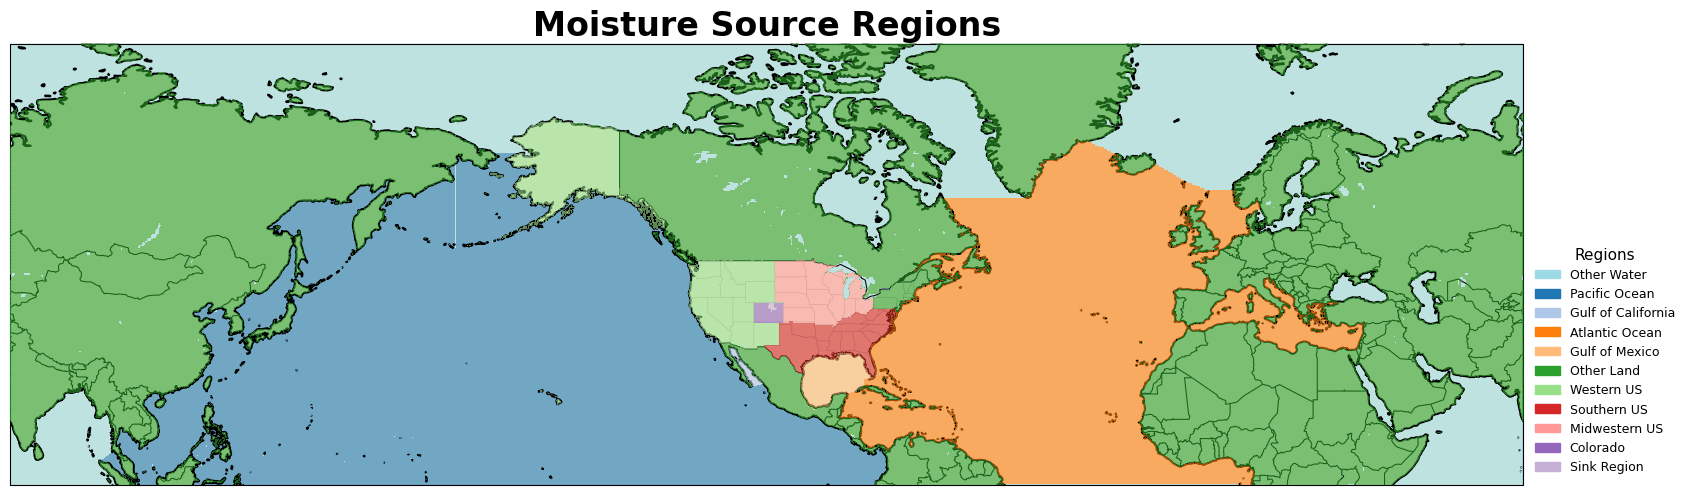

In [5]:
mask_dict = {'Other Water': other_w_bin,
    'Pacific Ocean': pacific,
    'Gulf of California': goc,
    'Atlantic Ocean': atlantic,
    'Gulf of Mexico': gom,
    'Other Land': other_l_bin,
    'Western US': west,
    'Southern US': south,
    'Midwestern US': mid,
    'Colorado': co,
    'Sink Region': sink_reg}

region_names = list(mask_dict.keys())

# create custom color palette
base_colors = list(plt.get_cmap('tab20').colors)
new_color_hex = '#50C878'
new_color_rgb = hex2color(new_color_hex)

colors = [base_colors[-1]] + base_colors[0:]

#set up figure plot
fig, ax = plt.subplots(figsize=(17, 12),
                       subplot_kw={'projection': ccrs.Miller(central_longitude=-106)})
ax.set_extent([-180, 179, 0, 80], crs=ccrs.PlateCarree())

# Plot each region mask individually
for i, (label, mask) in enumerate(mask_dict.items()):
    mask.where(mask == 1).plot(
        ax=ax,
        transform=ccrs.PlateCarree(),
        cmap=ListedColormap([colors[i]]),
        add_colorbar=False,
        alpha=0.6,
        zorder=i,
        rasterized=True
    )

# Add coastlines and borders
ax.coastlines(resolution='50m', linewidth=1.5)
ax.add_feature(cartopy.feature.BORDERS.with_scale('50m'), edgecolor='black', linewidth = 0.75)
ax.add_feature(cartopy.feature.STATES, linewidth=0.3, edgecolor='gray', alpha=0.5)
ax.set_facecolor('#efefdb')

# Create a custom legend
handles = [mpl.patches.Patch(color=colors[i], label=region_names[i]) for i in range(len(region_names))]
ax.legend(handles=handles, loc='lower left', bbox_to_anchor=(1, 0), title="Regions", fontsize=9, title_fontsize=11, frameon=False)

plt.title("Moisture Source Regions", fontsize=24, weight='bold')
plt.tight_layout()
plt.savefig('/Users/kathum/Research/COPEX/figures/moisture_source_regions_map.png', bbox_inches='tight', dpi=500)


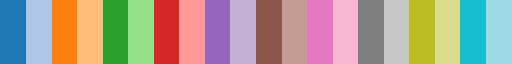

In [76]:
plt.get_cmap('tab20')